<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Naive-Bayes" data-toc-modified-id="Naive-Bayes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Naive Bayes</a></span><ul class="toc-item"><li><span><a href="#Experiment-Pipeline" data-toc-modified-id="Experiment-Pipeline-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Experiment Pipeline</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#Elastic-Net" data-toc-modified-id="Elastic-Net-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Elastic Net</a></span><ul class="toc-item"><li><span><a href="#Experiment-pipeline" data-toc-modified-id="Experiment-pipeline-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Experiment pipeline</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>RandomForest</a></span><ul class="toc-item"><li><span><a href="#Experiment-Pipeline" data-toc-modified-id="Experiment-Pipeline-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Experiment Pipeline</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#Light-Gradient-Boosting" data-toc-modified-id="Light-Gradient-Boosting-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Light Gradient Boosting</a></span><ul class="toc-item"><li><span><a href="#Experiment-Pipeline" data-toc-modified-id="Experiment-Pipeline-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Experiment Pipeline</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#Evaluate-out-of-sample-performance" data-toc-modified-id="Evaluate-out-of-sample-performance-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Evaluate out of sample performance</a></span></li></ul></div>

In this experiment we will build a simple pipeline using thew training set along with the handfull of binary features engineered during the project initiation stage to train classifiers using:

- Naive Bayes
- Elastic Net
- RandomForest
- Light Gradient Boosting

**Main difference from experiment 1**: we will leverage unstructured text in APPLICANT and DEVICENAME fields to engineer features wieghted by TF-IDF.

We will monitor `matthews_corrcoef` when training the classifiers and then document `classification_report` for both training and validation sets.

In [1]:
e_num = '3'

## Naive Bayes

### Experiment Pipeline

In [40]:
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef,make_scorer, balanced_accuracy_score
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer 
import pickle as pkl
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
start_time = datetime.now()

np.random.seed(1235)

# load the configuration file
with open("config.json",'rb') as f:
    config = json.load(f)
feature_store_dir = config['feature_store_dir']    

# Load data sets, prepare x_train and y_train
analytical_data = pd.read_csv(feature_store_dir + 'analytical_data.csv')
train_knumber = pd.read_csv(feature_store_dir + 'train_KNUMBER.csv')
dummy_features = pd.read_csv(feature_store_dir + "features_dummy.csv")

x_train = pd.merge(train_knumber[['KNUMBER','DATASET']],
    analytical_data[['KNUMBER','COMPLEXITY','APPLICANT','DEVICENAME']], how='left', on = "KNUMBER")
x_train = pd.merge(x_train,dummy_features, how = 'left', on='KNUMBER')
x_train['TEXT'] = x_train['APPLICANT'] + " " + x_train['DEVICENAME']

# MCC scorer for GridSearchCV
mcc = make_scorer(matthews_corrcoef)

def oversample(train_set):
    # Determine the oversampling needed 
    class_freq = train_set.loc[:,"COMPLEXITY"].value_counts()
    class_max = train_set.loc[:,"COMPLEXITY"].value_counts().max()
    class_freq = class_freq - class_max
    minority_classes = class_freq.index[class_freq < 0].tolist()
    # Implement random oversampling
    for mc in minority_classes:
        # number of oversamples needed
        n_samples = abs(class_freq[mc])
        # get respective class samples from the training set
        mc_data = train_set[train_set.COMPLEXITY == mc].copy()
        # random sample from mc_data to give desired n_samples
        mc_random_indx = np.random.choice(range(mc_data.shape[0]),replace=True,size=n_samples)
        # Sample this data and concatenate into train_set
        train_set =  pd.concat([train_set,mc_data.iloc[mc_random_indx,:]])
    # Shuffle the training set
    train_set = shuffle(train_set,random_state=123)
    return train_set

x_train = oversample(x_train)
# Encode target labels:
# 0 = L, 1 = M, 2 = H
y_train = x_train[['KNUMBER','COMPLEXITY']].copy()
y_train.loc[:,'value'] = 0
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'M'] = 1
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'H'] = 2
y_train = y_train.loc[:,'value'].values

def prepare_input(train_set):
    # Only retain numeric features
    train_set = train_set.drop(['KNUMBER','DATASET', 'COMPLEXITY',
                                'APPLICANT','DEVICENAME','TEXT'],axis = 1)
    return train_set

def prepare_input_text(train_set):
    train_set = train_set["TEXT"].copy()
    return train_set

clf_pipeline = Pipeline(steps=[
    ("union",FeatureUnion(
        transformer_list =[ ## !! CONTINUE HERE !! ##
            ("numeric_subpipeline",Pipeline(steps=[('prepare_input',
                                                    FunctionTransformer(prepare_input))])),
            # Branching point of the FeatureUnion
            ("text_subpipeline",Pipeline(steps=[("prepare_input_text",
                                                   FunctionTransformer(prepare_input_text)),
                                                 ("tokenizer",
                                                  TfidfVectorizer(stop_words ='english',
                                                                  ngram_range=(1,3),
                                                                  binary = False,
                                                                  max_df = 0.8))
                                               ]))
    ]) ),# Branching point to the main pipeline: at this point all features are numeric
    
    
    ("clf",MultinomialNB())
])

param_grid = {  'union__text_subpipeline__tokenizer__min_df':[0.05,0.1,0.2,0.3],
                'union__text_subpipeline__tokenizer__norm': ['l2','l1'],
                "clf__alpha":np.linspace(1,100,10),
                "clf__fit_prior":[True,False],
                
             }

clf_search = GridSearchCV(clf_pipeline,
                          param_grid = param_grid,
                          scoring = mcc,
                          cv = 5,
                          n_jobs=7,
                          verbose=7
                          )
clf_search.fit(X = x_train,y = y_train)

end_time = datetime.now()

print("Time elapsed: "+ str(round((end_time - start_time).seconds/60,4)) + " minutes.")

C:\Users\OZAN\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fitting 5 folds for each of 160 candidates, totalling 800 fits


C:\Users\OZAN\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.09713787 0.09790131 0.10007744 0.10007744        nan        nan
        nan        nan 0.0848408  0.0856094  0.08612158 0.08612158
        nan        nan        nan        nan 0.09709698 0.09790131
 0.10007744 0.10007744        nan        nan        nan        nan
 0.08480181 0.0856094  0.08612158 0.08612158        nan        nan
        nan        nan 0.09863505 0.09790131 0.10007744 0.10007744
        nan        nan        nan        nan 0.08633988 0.08542923
 0.08612158 0.08612158        nan        nan        nan        nan
 0.09859417 0.09768026 0.10007744 0.10007744        nan        nan
        nan        nan 0.08630088 0.08539024 0.08612158 0.08612158
        nan        nan        nan        nan 0.09859417 0.09780193
 0.10007744 0.10007744        nan        nan        nan        nan
 0.08630088 0.08551191 0.08612158 0.08612158        na

Time elapsed: 2.95 minutes.


### Summary

Pipeline hyperparameters that performed the best:
{'clf__alpha': 1.0, 'clf__fit_prior': True, 'union__text_subpipeline__tokenizer__min_df': 0.1, 'union__text_subpipeline__tokenizer__norm': 'l2'}

Best cross-validated performance estimate (MCC): 0.1001

MCC estimate (training set):  0.0861

Balanced accuracy (training set): 0.3765

Classification report (training set):

              precision    recall  f1-score   support

           0       0.36      0.83      0.50     14307
           1       0.33      0.13      0.18     14307
           2       0.57      0.17      0.26     14307

    accuracy                           0.38     42921
   macro avg       0.42      0.38      0.32     42921
weighted avg       0.42      0.38      0.32     42921


Confusion matrix (training set):

[[11906  1750   651]
 [11270  1828  1209]
 [ 9991  1891  2425]]


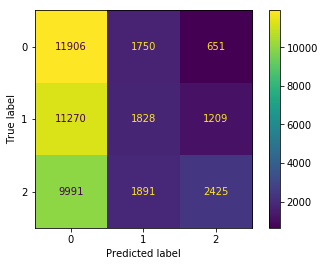

In [41]:
print('Pipeline hyperparameters that performed the best:')
print(clf_search.best_params_)
print("")
print("Best cross-validated performance estimate (MCC): "+ str(np.round(clf_search.best_score_,4)))
print("")
print("MCC estimate (training set): ", str(np.round(matthews_corrcoef(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print("Balanced accuracy (training set): "+ 
      str(np.round(balanced_accuracy_score(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print('Classification report (training set):')
print("")
print(classification_report(y_true = y_train, y_pred = clf_search.predict(x_train)))
print("")
print("Confusion matrix (training set):")
print("")
print(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di = ConfusionMatrixDisplay(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di.plot()
plt.show()
# Save the trained GridSearchCV object
with open("./models/experiment_" + e_num + "/naive_bayes.pkl","wb") as f:
    pkl.dump(clf_search,f)

## Elastic Net

### Experiment pipeline

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef,make_scorer, balanced_accuracy_score
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle as pkl
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime 

start_time = datetime.now()

# load the configuration file
with open("config.json",'rb') as f:
    config = json.load(f)
feature_store_dir = config['feature_store_dir']    

# Load data sets, prepare x_train and y_train
analytical_data = pd.read_csv(feature_store_dir + 'analytical_data.csv')
train_knumber = pd.read_csv(feature_store_dir + 'train_KNUMBER.csv')
dummy_features = pd.read_csv(feature_store_dir + "features_dummy.csv")

x_train = pd.merge(train_knumber[['KNUMBER','DATASET']],
    analytical_data[['KNUMBER','COMPLEXITY','APPLICANT','DEVICENAME']], how='left', on = "KNUMBER")
x_train = pd.merge(x_train,dummy_features, how = 'left', on='KNUMBER')
x_train['TEXT'] = x_train['APPLICANT'] + " " + x_train['DEVICENAME']

# MCC scorer for GridSearchCV
mcc = make_scorer(matthews_corrcoef)

def oversample(train_set):
    # Determine the oversampling needed 
    class_freq = train_set.loc[:,"COMPLEXITY"].value_counts()
    class_max = train_set.loc[:,"COMPLEXITY"].value_counts().max()
    class_freq = class_freq - class_max
    minority_classes = class_freq.index[class_freq < 0].tolist()
    # Implement random oversampling
    for mc in minority_classes:
        # number of oversamples needed
        n_samples = abs(class_freq[mc])
        # get respective class samples from the training set
        mc_data = train_set[train_set.COMPLEXITY == mc].copy()
        # random sample from mc_data to give desired n_samples
        mc_random_indx = np.random.choice(range(mc_data.shape[0]),replace=True,size=n_samples)
        # Sample this data and concatenate into train_set
        train_set =  pd.concat([train_set,mc_data.iloc[mc_random_indx,:]])
    # Shuffle the training set
    train_set = shuffle(train_set,random_state=123)
    return train_set

x_train = oversample(x_train)
# Encode target labels:
# 0 = L, 1 = M, 2 = H
y_train = x_train[['KNUMBER','COMPLEXITY']].copy()
y_train.loc[:,'value'] = 0
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'M'] = 1
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'H'] = 2
y_train = y_train.loc[:,'value'].values

def prepare_input(train_set):
    # Only retain numeric features
    train_set = train_set.drop(['KNUMBER','DATASET', 'COMPLEXITY',
                                'APPLICANT','DEVICENAME','TEXT'],axis = 1)
    return train_set

def prepare_input_text(train_set):
    train_set = train_set["TEXT"].copy()
    return train_set

clf_pipeline = Pipeline(steps=[
    ("union",FeatureUnion(
        transformer_list =[ ## !! CONTINUE HERE !! ##
            ("numeric_subpipeline",Pipeline(steps=[('prepare_input',
                                                    FunctionTransformer(prepare_input))])),
            # Branching point of the FeatureUnion
            ("text_subpipeline",Pipeline(steps=[("prepare_input_text",
                                                   FunctionTransformer(prepare_input_text)),
                                                 ("tokenizer",
                                                  TfidfVectorizer(stop_words ='english',
                                                                  ngram_range=(1,3),
                                                                  binary = False,
                                                                  max_df = 0.8))
                                               ]))
    ]) ),# Branching point to the main pipeline: at this point all features are numeric
    
    ("clf",LogisticRegression(penalty = "elasticnet", solver='saga'))
])

param_grid = {  'union__text_subpipeline__tokenizer__min_df':[0.05,0.1,0.15],
                "clf__C":np.linspace(0,1,10).tolist() + np.linspace(1,100,10).tolist(),
                "clf__l1_ratio":np.linspace(0,1,10),
             }

clf_search = GridSearchCV(clf_pipeline,
                          param_grid = param_grid,
                          scoring = mcc,
                          cv = 5,
                          n_jobs=7,
                          verbose=7
                          )
clf_search.fit(X = x_train,y = y_train)

end_time = datetime.now()

print("Time elapsed: "+ str(round((end_time - start_time).seconds/60,4)) + " minutes.")

C:\Users\OZAN\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fitting 5 folds for each of 600 candidates, totalling 3000 fits


C:\Users\OZAN\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.12644362 0.14114853 0.14114853 0.12596379 0.14114853 0.14114853
 0.12595383 0.14114853 0.14114853 0.12595383 0.14114853 0.14114853
 0.12616979 0.14114853 0.14114853 0.12615382 0.14114853 0.14114853
 0.12767537 0.14114853 0.14114853 0.12767789 0.14114853 0.14114853
 0.12970597 0.14114853 0.14114853 0.13162662 0.14114853 0.14114853
 0.12595891 0.14114853 0.14114853 0.12598485 0.14114853 0.14114853
 0.12598485 0.14114853 0.14114853 0.12595383 0.14114853 0.14114853
 0.12595383 0.14114853 0.14114853 0.12595383 0.1411485

Time elapsed: 17.2 minutes.


### Summary

Pipeline hyperparameters that performed the best:
{'clf__C': 0.1111111111111111, 'clf__l1_ratio': 0.0, 'union__text_subpipeline__tokenizer__min_df': 0.1}

Best cross-validated performance estimate (MCC): 0.1411

MCC estimate (training set):  0.1412

Balanced accuracy (training set): 0.4064

Classification report (training set):

              precision    recall  f1-score   support

           0       0.56      0.25      0.34     14307
           1       0.36      0.80      0.49     14307
           2       0.57      0.17      0.26     14307

    accuracy                           0.41     42921
   macro avg       0.49      0.41      0.37     42921
weighted avg       0.49      0.41      0.37     42921


Confusion matrix (training set):

[[ 3560 10118   629]
 [ 1624 11474  1209]
 [ 1186 10712  2409]]


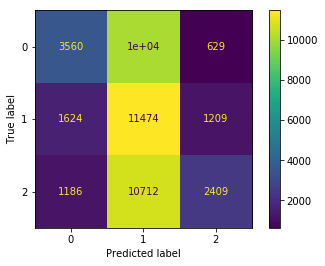

In [4]:
print('Pipeline hyperparameters that performed the best:')
print(clf_search.best_params_)
print("")
print("Best cross-validated performance estimate (MCC): "+ str(np.round(clf_search.best_score_,4)))
print("")
print("MCC estimate (training set): ", str(np.round(matthews_corrcoef(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print("Balanced accuracy (training set): "+ 
      str(np.round(balanced_accuracy_score(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print('Classification report (training set):')
print("")
print(classification_report(y_true = y_train, y_pred = clf_search.predict(x_train)))
print("")
print("Confusion matrix (training set):")
print("")
print(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di = ConfusionMatrixDisplay(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di.plot()
plt.show()
# Save the trained GridSearchCV object
with open("./models/experiment_" + e_num + "/elastic_net.pkl","wb") as f:
    pkl.dump(clf_search,f)

## RandomForest

### Experiment Pipeline

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef,make_scorer, balanced_accuracy_score
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.feature_selection import SelectKBest,chi2,SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle as pkl
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime 

start_time = datetime.now()

# load the configuration file
with open("config.json",'rb') as f:
    config = json.load(f)
feature_store_dir = config['feature_store_dir']    

# Load data sets, prepare x_train and y_train
analytical_data = pd.read_csv(feature_store_dir + 'analytical_data.csv')
train_knumber = pd.read_csv(feature_store_dir + 'train_KNUMBER.csv')
dummy_features = pd.read_csv(feature_store_dir + "features_dummy.csv")

x_train = pd.merge(train_knumber[['KNUMBER','DATASET']],
    analytical_data[['KNUMBER','COMPLEXITY','APPLICANT','DEVICENAME']], how='left', on = "KNUMBER")
x_train = pd.merge(x_train,dummy_features, how = 'left', on='KNUMBER')
x_train['TEXT'] = x_train['APPLICANT'] + " " + x_train['DEVICENAME']

# MCC scorer for GridSearchCV
mcc = make_scorer(matthews_corrcoef)

def oversample(train_set):
    # Determine the oversampling needed 
    class_freq = train_set.loc[:,"COMPLEXITY"].value_counts()
    class_max = train_set.loc[:,"COMPLEXITY"].value_counts().max()
    class_freq = class_freq - class_max
    minority_classes = class_freq.index[class_freq < 0].tolist()
    # Implement random oversampling
    for mc in minority_classes:
        # number of oversamples needed
        n_samples = abs(class_freq[mc])
        # get respective class samples from the training set
        mc_data = train_set[train_set.COMPLEXITY == mc].copy()
        # random sample from mc_data to give desired n_samples
        mc_random_indx = np.random.choice(range(mc_data.shape[0]),replace=True,size=n_samples)
        # Sample this data and concatenate into train_set
        train_set =  pd.concat([train_set,mc_data.iloc[mc_random_indx,:]])
    # Shuffle the training set
    train_set = shuffle(train_set,random_state=123)
    return train_set

x_train = oversample(x_train)
# Encode target labels:
# 0 = L, 1 = M, 2 = H
y_train = x_train[['KNUMBER','COMPLEXITY']].copy()
y_train.loc[:,'value'] = 0
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'M'] = 1
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'H'] = 2
y_train = y_train.loc[:,'value'].values

def prepare_input(train_set):
    # Only retain numeric features
    train_set = train_set.drop(['KNUMBER','DATASET', 'COMPLEXITY',
                                'APPLICANT','DEVICENAME','TEXT'],axis = 1)
    return train_set

def prepare_input_text(train_set):
    train_set = train_set["TEXT"].copy()
    return train_set

clf_pipeline = Pipeline(steps=[
    ("union",FeatureUnion(
        transformer_list =[ ## !! CONTINUE HERE !! ##
            ("numeric_subpipeline",Pipeline(steps=[('prepare_input',
                                                    FunctionTransformer(prepare_input))])),
            # Branching point of the FeatureUnion
            ("text_subpipeline",Pipeline(steps=[("prepare_input_text",
                                                   FunctionTransformer(prepare_input_text)),
                                                 ("tokenizer",
                                                  TfidfVectorizer(stop_words ='english',
                                                                  ngram_range=(1,3),
                                                                  binary = False,
                                                                  max_df = 0.8))
                                               ]))
    ]) ),# Branching point to the main pipeline: at this point all features are numeric
    ("clf",RandomForestClassifier(n_estimators = 300,random_state = 123))
])

param_grid = {  'union__text_subpipeline__tokenizer__min_df':[0.0025,0.005,0.01,0.05],
                "clf__min_samples_leaf":[5,10,25,50,100],
             }

clf_search = GridSearchCV(clf_pipeline,
                          param_grid = param_grid,
                          scoring = mcc,
                          cv = 5,
                          n_jobs=7,
                          verbose=7
                          )
clf_search.fit(X = x_train,y = y_train)

end_time = datetime.now()

print("Time elapsed: "+ str(round((end_time - start_time).seconds/60,4)) + " minutes.")

C:\Users\OZAN\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Time elapsed: 3.6333 minutes.


In [34]:
x = TfidfVectorizer(stop_words ='english', min_df=0.0025,
                    ngram_range=(1,3),
                    binary = False,max_df = 0.8).fit(prepare_input_text(x_train))
len(x.vocabulary_)

457

### Summary

Pipeline hyperparameters that performed the best:
{'clf__min_samples_leaf': 5, 'union__text_subpipeline__tokenizer__min_df': 0.0025}

Best cross-validated performance estimate (MCC): 0.3314

MCC estimate (training set):  0.4614

Balanced accuracy (training set): 0.637

Classification report (training set):

              precision    recall  f1-score   support

           0       0.65      0.68      0.67     14307
           1       0.64      0.45      0.53     14307
           2       0.62      0.78      0.69     14307

    accuracy                           0.64     42921
   macro avg       0.64      0.64      0.63     42921
weighted avg       0.64      0.64      0.63     42921


Confusion matrix (training set):

[[ 9748  2021  2538]
 [ 3615  6460  4232]
 [ 1608  1567 11132]]


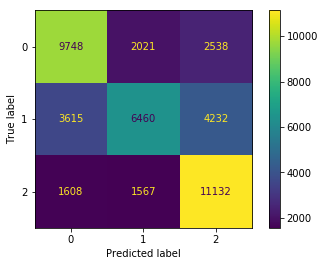

In [36]:
print('Pipeline hyperparameters that performed the best:')
print(clf_search.best_params_)
print("")
print("Best cross-validated performance estimate (MCC): "+ str(np.round(clf_search.best_score_,4)))
print("")
print("MCC estimate (training set): ", str(np.round(matthews_corrcoef(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print("Balanced accuracy (training set): "+ 
      str(np.round(balanced_accuracy_score(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print('Classification report (training set):')
print("")
print(classification_report(y_true = y_train, y_pred = clf_search.predict(x_train)))
print("")
print("Confusion matrix (training set):")
print("")
print(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di = ConfusionMatrixDisplay(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di.plot()
plt.show()
# Save the trained GridSearchCV object
with open("./models/experiment_" + e_num + "/randomForest.pkl","wb") as f:
    pkl.dump(clf_search,f)

## Light Gradient Boosting
### Experiment Pipeline

In [37]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef,make_scorer, balanced_accuracy_score
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle as pkl
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime 

start_time = datetime.now()

# load the configuration file
with open("config.json",'rb') as f:
    config = json.load(f)
feature_store_dir = config['feature_store_dir']    

# Load data sets, prepare x_train and y_train
analytical_data = pd.read_csv(feature_store_dir + 'analytical_data.csv')
train_knumber = pd.read_csv(feature_store_dir + 'train_KNUMBER.csv')
dummy_features = pd.read_csv(feature_store_dir + "features_dummy.csv")

x_train = pd.merge(train_knumber[['KNUMBER','DATASET']],
    analytical_data[['KNUMBER','COMPLEXITY','APPLICANT','DEVICENAME']], how='left', on = "KNUMBER")
x_train = pd.merge(x_train,dummy_features, how = 'left', on='KNUMBER')
x_train['TEXT'] = x_train['APPLICANT'] + " " + x_train['DEVICENAME']

# MCC scorer for GridSearchCV
mcc = make_scorer(matthews_corrcoef)

def oversample(train_set):
    # Determine the oversampling needed 
    class_freq = train_set.loc[:,"COMPLEXITY"].value_counts()
    class_max = train_set.loc[:,"COMPLEXITY"].value_counts().max()
    class_freq = class_freq - class_max
    minority_classes = class_freq.index[class_freq < 0].tolist()
    # Implement random oversampling
    for mc in minority_classes:
        # number of oversamples needed
        n_samples = abs(class_freq[mc])
        # get respective class samples from the training set
        mc_data = train_set[train_set.COMPLEXITY == mc].copy()
        # random sample from mc_data to give desired n_samples
        mc_random_indx = np.random.choice(range(mc_data.shape[0]),replace=True,size=n_samples)
        # Sample this data and concatenate into train_set
        train_set =  pd.concat([train_set,mc_data.iloc[mc_random_indx,:]])
    # Shuffle the training set
    train_set = shuffle(train_set,random_state=123)
    return train_set

x_train = oversample(x_train)
# Encode target labels:
# 0 = L, 1 = M, 2 = H
y_train = x_train[['KNUMBER','COMPLEXITY']].copy()
y_train.loc[:,'value'] = 0
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'M'] = 1
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'H'] = 2
y_train = y_train.loc[:,'value'].values

def prepare_input(train_set):
    # Only retain numeric features
    train_set = train_set.drop(['KNUMBER','DATASET', 'COMPLEXITY',
                                'APPLICANT','DEVICENAME','TEXT'],axis = 1)
    return train_set

def prepare_input_text(train_set):
    train_set = train_set["TEXT"].copy()
    return train_set

clf_pipeline = Pipeline(steps=[
    ("union",FeatureUnion(
        transformer_list =[ ## !! CONTINUE HERE !! ##
            ("numeric_subpipeline",Pipeline(steps=[('prepare_input',
                                                    FunctionTransformer(prepare_input))])),
            # Branching point of the FeatureUnion
            ("text_subpipeline",Pipeline(steps=[("prepare_input_text",
                                                   FunctionTransformer(prepare_input_text)),
                                                 ("tokenizer",
                                                  TfidfVectorizer(stop_words ='english',
                                                                  ngram_range=(1,3),
                                                                  binary = False,
                                                                  max_df = 0.8))
                                               ]))
    ]) ),# Branching point to the main pipeline: at this point all features are numeric
    ("clf",LGBMClassifier(n_estimators = 300,
                          objective = 'multiclass',
                          random_state = 123))
])

param_grid = {  'union__text_subpipeline__tokenizer__min_df':[0.0025,0.005,0.01],
                "clf__min_child_samples":[5,10,25,50],
                "clf__num_leaves":[15,31,60],
             }

clf_search = GridSearchCV(clf_pipeline,
                          param_grid = param_grid,
                          scoring = mcc,
                          cv = 5,
                          n_jobs=7,
                          verbose=7
                          )
clf_search.fit(X = x_train,y = y_train)

end_time = datetime.now()

print("Time elapsed: "+ str(round((end_time - start_time).seconds/60,4)) + " minutes.")

C:\Users\OZAN\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Time elapsed: 10.35 minutes.


### Summary

Pipeline hyperparameters that performed the best:
{'clf__min_child_samples': 5, 'clf__num_leaves': 60, 'union__text_subpipeline__tokenizer__min_df': 0.0025}

Best cross-validated performance estimate (MCC): 0.4135

MCC estimate (training set):  0.5934

Balanced accuracy (training set): 0.7251

Classification report (training set):

              precision    recall  f1-score   support

           0       0.74      0.75      0.75     14307
           1       0.76      0.57      0.65     14307
           2       0.69      0.85      0.76     14307

    accuracy                           0.73     42921
   macro avg       0.73      0.73      0.72     42921
weighted avg       0.73      0.73      0.72     42921


Confusion matrix (training set):

[[10761  1563  1983]
 [ 2696  8167  3444]
 [ 1054  1058 12195]]


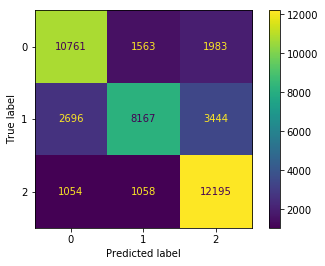

In [38]:
print('Pipeline hyperparameters that performed the best:')
print(clf_search.best_params_)
print("")
print("Best cross-validated performance estimate (MCC): "+ str(np.round(clf_search.best_score_,4)))
print("")
print("MCC estimate (training set): ", str(np.round(matthews_corrcoef(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print("Balanced accuracy (training set): "+ 
      str(np.round(balanced_accuracy_score(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print('Classification report (training set):')
print("")
print(classification_report(y_true = y_train, y_pred = clf_search.predict(x_train)))
print("")
print("Confusion matrix (training set):")
print("")
print(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di = ConfusionMatrixDisplay(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di.plot()
plt.show()
# Save the trained GridSearchCV object
with open("./models/experiment_" + e_num + "/lgbm.pkl","wb") as f:
    pkl.dump(clf_search,f)

## Evaluate out of sample performance

C:\Users\OZAN\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

Best cross-validated performance estimate (MCC): 0.4135

MCC estimate (training set):  0.4821

Balanced accuracy (training set): 0.7003

Classification report (training set):

              precision    recall  f1-score   support

           0       0.61      0.71      0.66      6668
           1       0.86      0.57      0.69     14307
           2       0.42      0.82      0.56      3951

    accuracy                           0.65     24926
   macro avg       0.63      0.70      0.63     24926
weighted avg       0.73      0.65      0.66     24926


Confusion matrix (training set):

[[4742  926 1000]
 [2696 8167 3444]
 [ 346  369 3236]]


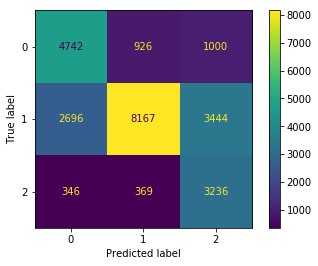

***************************************************************************

MCC estimate (validation set):  0.0885

Balanced accuracy (validation set): 0.4124

Classification report (validation set):

              precision    recall  f1-score   support

           0       0.38      0.40      0.39      1249
           1       0.55      0.42      0.48      2456
           2       0.26      0.42      0.32       819

    accuracy                           0.41      4524
   macro avg       0.40      0.41      0.39      4524
weighted avg       0.45      0.41      0.42      4524


Confusion matrix (validation set):

[[ 497  502  250]
 [ 680 1036  740]
 [ 133  344  342]]


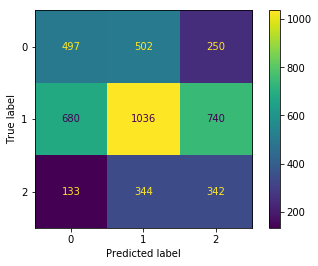

In [11]:
import pickle as pkl
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import matthews_corrcoef,make_scorer, balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


np.random.seed(1235)

# load the configuration file
with open("config.json",'rb') as f:
    config = json.load(f)
feature_store_dir = config['feature_store_dir']    

# Load data sets, prepare x_train and y_train 
analytical_data = pd.read_csv(feature_store_dir + 'analytical_data.csv')
train_knumber = pd.read_csv(feature_store_dir + 'train_KNUMBER.csv')
dummy_features = pd.read_csv(feature_store_dir + "features_dummy.csv")

x_train = pd.merge(train_knumber[['KNUMBER','DATASET']],
    analytical_data[['KNUMBER','COMPLEXITY','APPLICANT','DEVICENAME']], how='left', on = "KNUMBER")
x_train = pd.merge(x_train,dummy_features, how = 'left', on='KNUMBER')
x_train['TEXT'] = x_train['APPLICANT'] + " " + x_train['DEVICENAME']

y_train = x_train[['KNUMBER','COMPLEXITY']].copy()
y_train.loc[:,'value'] = 0
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'M'] = 1
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'H'] = 2
y_train = y_train.loc[:,'value'].values

# Load data sets, prepare X_val, y_val
val_knumber = pd.read_csv(feature_store_dir + 'validation_KNUMBER.csv')
x_val = pd.merge(val_knumber[['KNUMBER','DATASET']],
    analytical_data[['KNUMBER','COMPLEXITY','APPLICANT','DEVICENAME']], how='left', on = "KNUMBER")
x_val = pd.merge(x_val,dummy_features, how = 'left', on='KNUMBER')
x_val['TEXT'] = x_val['APPLICANT'] + " " + x_val['DEVICENAME']

y_val = x_val[['KNUMBER','COMPLEXITY']].copy()
y_val.loc[:,'value'] = 0
y_val.loc[:,'value'][y_val.loc[:,'COMPLEXITY'] == 'M'] = 1
y_val.loc[:,'value'][y_val.loc[:,'COMPLEXITY'] == 'H'] = 2
y_val = y_val.loc[:,'value'].values

def prepare_input(train_set):
    # Only retain numeric features
    train_set = train_set.drop(['KNUMBER','DATASET', 'COMPLEXITY',
                                'APPLICANT','DEVICENAME','TEXT'],axis = 1)
    return train_set

def prepare_input_text(train_set):
    train_set = train_set["TEXT"].copy()
    return train_set

with open("./models/experiment_" + e_num + "/lgbm.pkl","rb") as f:
    clf_search = pkl.load(f)

print("Best cross-validated performance estimate (MCC): "+ str(np.round(clf_search.best_score_,4)))
print("")
print("MCC estimate (training set): ", str(np.round(matthews_corrcoef(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print("Balanced accuracy (training set): "+ 
      str(np.round(balanced_accuracy_score(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print('Classification report (training set):')
print("")
print(classification_report(y_true = y_train, y_pred = clf_search.predict(x_train)))
print("")
print("Confusion matrix (training set):")
print("")
print(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di = ConfusionMatrixDisplay(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di.plot()
plt.show()

print("*" * 75)

print("")
print("MCC estimate (validation set): ", str(np.round(matthews_corrcoef(y_true = y_val, 
        y_pred = clf_search.predict(x_val)),4)))
print("")
print("Balanced accuracy (validation set): "+ 
      str(np.round(balanced_accuracy_score(y_true = y_val, 
        y_pred = clf_search.predict(x_val)),4)))
print("")
print('Classification report (validation set):')
print("")
print(classification_report(y_true = y_val, y_pred = clf_search.predict(x_val)))
print("")
print("Confusion matrix (validation set):")
print("")
print(confusion_matrix(y_true = y_val, y_pred = clf_search.predict(x_val)))
di = ConfusionMatrixDisplay(confusion_matrix(y_true = y_val, y_pred = clf_search.predict(x_val)))
di.plot()
plt.show()